# EMP Metabolomics feature table distribution visualization

Author: Louis Felix Nothias, UC San Diego 

Date: 2021/01/11

### Objectifs:
Define the threshold for filtering feature intensities that are noise being introduced by the gap filling step
 
### Steps:

- Take and prepare the feature table and merge it with the metadata
- Visualize the distribution of intensities based on main metadata ("lcms_sample_type", "lcms_sample_type_sub")

### Code notes
The code should handle standard ion identity networking table but the metadata handling has specific handling for the EMP500 metadata table. 

## Prepare the script -> run the following cells

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Define the feature tables
filename_before_gapfill = 'feature_table/EMPsubset_before_gapfill_quant.csv'
filename_after_gapfill = 'feature_table/EMPsubset_after_gapfill_quant.csv'

#Define metadata filename
metadata_filename = 'metadata/emp500_metadata_basic.txt'

In [3]:
# This function takes a feature table and metadata table. Concatenate them. Filter based on metadata and visualize.
def function(filename,max_intensity,subset1=None,value1=None,subset2=None, value2=None, plot_color='Blue',\
             xmax=1E8, xmax_zoom=1E7):
    ft = pd.read_table(filename, index_col=None, header=0, sep=',', low_memory=False, skiprows=0)
    #Drop IIN columns
    ft = ft.drop(columns=['row m/z','row retention time','correlation group ID', 'annotation network number','best ion','auto MS2 verify','identified by n=','partners','neutral M mass'])
    # Get the correct column type
    ft = ft.infer_objects()
    ft = ft.set_index('row ID', drop=True)
    # Tranpose the table
    ft_T = ft.T
    ft_T['duplicate_check'] = ft_T.index

    # Removing metabolomics sample duplicate filenames (these are not critical samples, mostly technical samples)
    ft2 = ft_T
    ft2 = ft2[~ft2.duplicate_check.str.contains("Unnamed: 815")]
    ft2 = ft2[~ft2.duplicate_check.str.contains("Peak area.")]
    ft2["duplicate_check"] = ft2["duplicate_check"].str.rstrip(" croppped Peak area")
    #ft2 = ft2.drop(columns=['duplicate_check']) 
    ft2 = ft2.set_index('duplicate_check', drop=True)
    
    # Replace 0 by NaN
    ft2 = ft2.replace(0,np.nan)
    ft2["lcms_sample_name_fbmn"] = ft2.index
    ft2.head(3)
    
    md = pd.read_table(metadata_filename, index_col=None, header=0, sep='\t', usecols=['lcms_sample_name_fbmn','lcms_extraction_protocol',
       'lcms_sample_type', 'lcms_sample_type_sub','lcms_batch','emp500_principal_investigator', 'emp500_study_id',
       'emp500_pi_study_id', 'emp500_title', 'empo_0', 'empo_1', 'empo_2',
       'empo_3', 'env_biome', 'env_feature', 'env_material'])

    md_filtered = md[~md.lcms_sample_name_fbmn.str.contains("not applicable")]
    md_filtered = md_filtered.infer_objects()
    
    #Change the column type for batch only interrogate (some potentially usefull samples don't have a batch)
    if subset2 == "lcms_batch":
        md_filtered = md_filtered[~md_filtered.lcms_batch.str.contains("not applicable")]
        md_filtered["lcms_batch"] = md_filtered["lcms_batch"].astype(float).astype(int)
    else:
        pass

    df = pd.merge(md_filtered,ft2, on=['lcms_sample_name_fbmn'], how='right')
    df.head(2)
    
    # Filter the table based on subset/value
    try: 
        df = df[df[subset1] == value1]
    except:
        pass
    try: 
        df = df[df[subset2] == value2]
    except:
        pass
    
    try: 
        for x in df.columns:
            if x in md.columns:
                df = df.drop(columns=[x])
    except:
        pass

    
    # Make a long list for visualization
    big_liste = []
    for x in df.columns:
        try:
            liste = df[x].to_list()
            liste = [x for x in liste if x <= max_intensity]
            big_liste = big_liste + liste
        except:
            continue
        
    # Visualize
    fig1, ax1 = plt.subplots(1,1, figsize = (10, 3), dpi=100)
    ax1 = sns.violinplot(x=big_liste,color=plot_color)
    ax1.set(xlabel="Feature intensity")
    plt.title("EMP: Distribution plot for metabolomics feature intensity (below "+str(max_intensity)+")\n for subset "+str(subset1)+"/"+str(value1)+" and "+str(subset2)+"/"+str(value2)+"\n Samples="+str(df.shape[0])+" Features="+str(df.shape[1]), size=12)
    ax1.set(xlim=(0,xmax))
    plt.show() 
    plt.close()

    fig2, ax2 = plt.subplots(1,1, figsize = (10, 3), dpi=100)
    ax2 = sns.distplot(big_liste, kde = None, bins = 1000, color=plot_color)
    ax2.set(xlabel="Feature intensity")
    ax2.set(ylabel="Count")
    ax2.set(xlim=(0, xmax))
    plt.show()
    plt.close()
    
    fig1, ax3 = plt.subplots(1,1, figsize = (10, 3), dpi=100)
    ax3 = sns.violinplot(x=big_liste,color=plot_color)
    ax3.set(xlim=(0, xmax_zoom))
    ax3.set(xlabel="Feature intensity")
    plt.show() 
    plt.close()

## Metadata examination -> run the following cell to see metadata columns

In [4]:
# Just run the cell
md = pd.read_table(metadata_filename, index_col=None, header=0, sep='\t', usecols=['lcms_sample_name_fbmn','lcms_extraction_protocol',
       'lcms_sample_type', 'lcms_sample_type_sub','lcms_batch','emp500_principal_investigator', 'emp500_study_id',
       'emp500_pi_study_id', 'emp500_title', 'empo_0', 'empo_1', 'empo_2',
       'empo_3', 'env_biome', 'env_feature', 'env_material'])
md_filtered = md[~md.lcms_sample_name_fbmn.str.contains("not applicable")]
md_filtered = md_filtered.infer_objects()
#md_filtered["lcms_batch"] = md_filtered["lcms_batch"].astype(float).astype(int)
print('This are the metadata columns')
md_filtered.dtypes
#list(md_filtered["lcms_batch"])

This are the metadata columns


lcms_sample_name_fbmn            object
lcms_batch                       object
lcms_extraction_protocol         object
lcms_sample_type                 object
lcms_sample_type_sub             object
emp500_principal_investigator    object
emp500_study_id                  object
emp500_pi_study_id               object
emp500_title                     object
empo_0                           object
empo_1                           object
empo_2                           object
empo_3                           object
env_biome                        object
env_feature                      object
env_material                     object
dtype: object

## Check the metadata values -> specify the subsets to be used for filtering

In [6]:
#Specify the subsets
subset1 = "lcms_sample_type"
subset2 = "lcms_batch"
subset3 = "lcms_sample_type_sub"

# The values in that column
print(subset1)
print(set(md_filtered[subset1]))
# The values in that column
print(subset2)
print(set(md_filtered[subset2]))
# The values in that column
print(subset3)
print(set(md_filtered[subset3]))

lcms_sample_type
{'QC6mix', 'Sample', 'Qcmix', 'not applicable', 'Blank', 'Material_control'}
lcms_batch
{'7.00', '8.11', '8.14', '8.10', '3.00', '8.18', '8.13', '1.00', '8.19', '8.04', '8.01', '8.17', '8.07', '8.12', '8.03', '8.15', '8.16', '6.00', 'not applicable', '5.00', '8.05', '2.00', '8.08', '4.00', '8.00', '8.06', '8.09', '8.02', '9.00'}
lcms_sample_type_sub
{'QC', 'Solvent', 'Swabs', 'Filter', 'SPE', 'not applicable', 'Blank', 'Bulk', 'Material_control'}


## Lets visualize the distribution for subset(s) -> run the cells

Green = before gap filling

Orange = after gap filling

### Solid Phase Extraction (SPE) and mass spec background controls before/after gap filling step

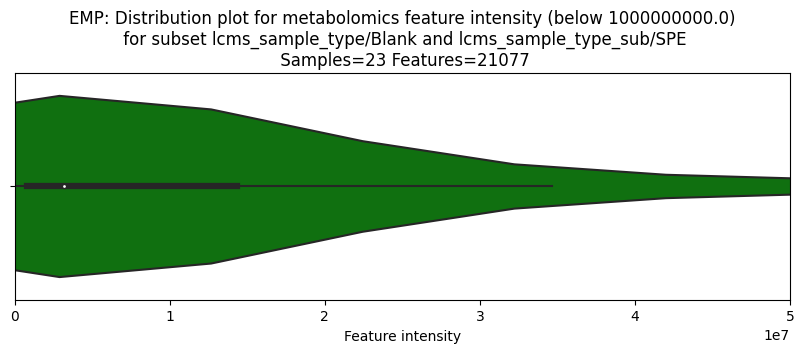

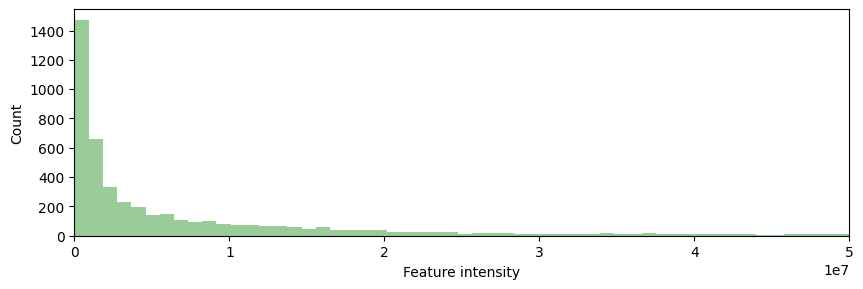

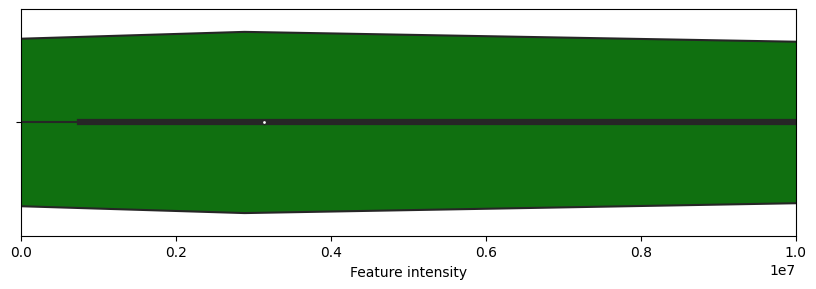

In [7]:
# View distribution for SPE background controls only
function(filename_before_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Blank", \
         subset2="lcms_sample_type_sub", value2="SPE",plot_color="green", xmax=5E7)
#function(filename_after_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Blank", \
#         subset2="lcms_sample_type_sub", value2="SPE",plot_color="orange", xmax=5E7, xmax_zoom=1E4)

### View distribution in solvent background controls

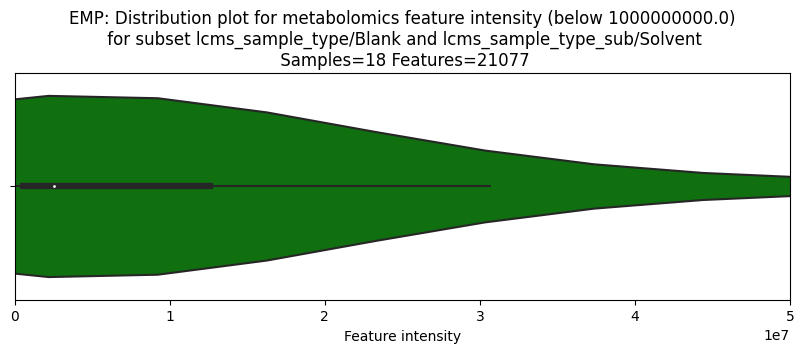

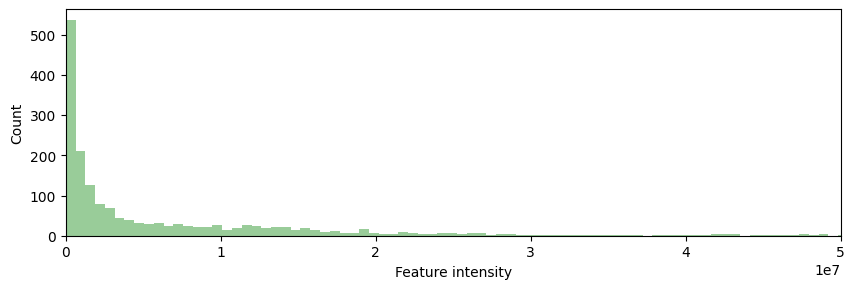

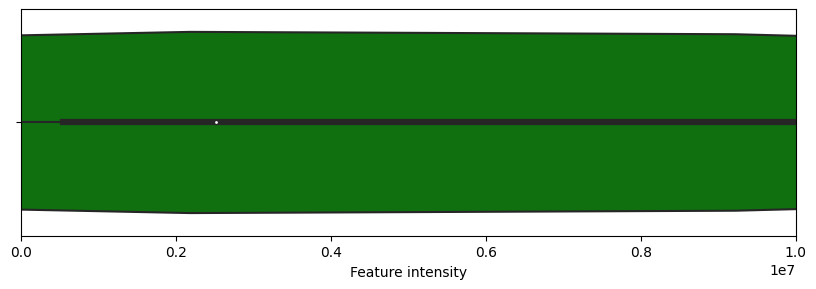

In [8]:
function(filename_before_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Blank", \
         subset2="lcms_sample_type_sub", value2="Solvent",plot_color="green", xmax=5E7)
#function(filename_after_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Blank", \
#         subset2="lcms_sample_type_sub", value2="Solvent",plot_color="green", xmax=5E7, xmax_zoom=1E4)

### Interpretation
By inspecting the feature intensity distribution for background controls in the feature table (before gap filling), we can see that generally 75% of the features have an intensity > 5E5. 

That seems like a conservative threshold to keep features that were clearly detected in samples (abscence/presence of compounds).
That value can be used for SPE/MS background control filtering, and background control filtering.

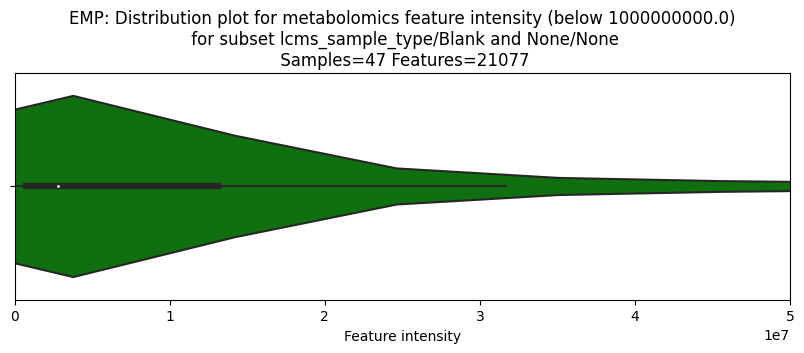

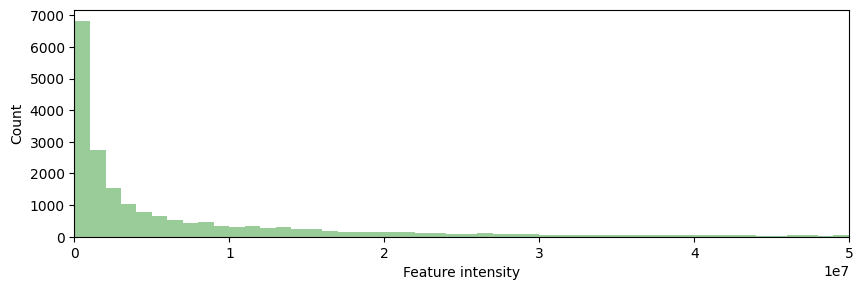

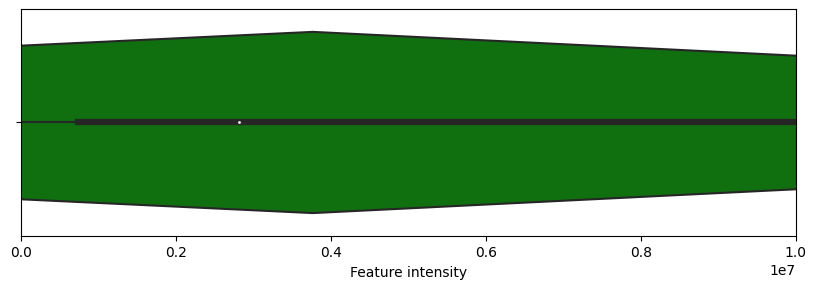

In [9]:
# View distribution all background controls
function(filename_before_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Blank", \
         plot_color="green", xmax=5E7)
#function(filename_after_gapfill, max_intensity=1E7, subset1="lcms_sample_type", value1="Blank", \
#         plot_color="orange", xmax=5E7, xmax_zoom=1E4)

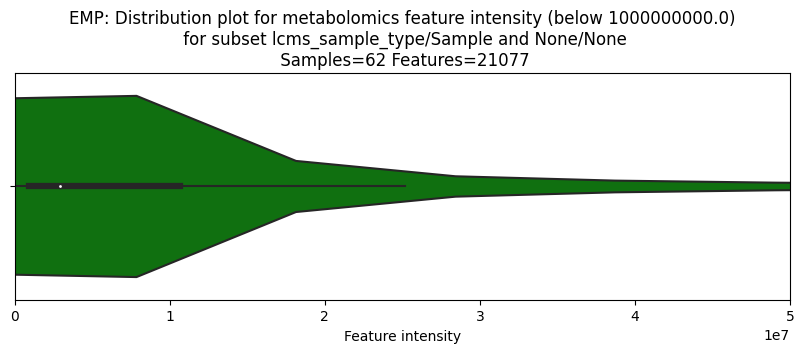

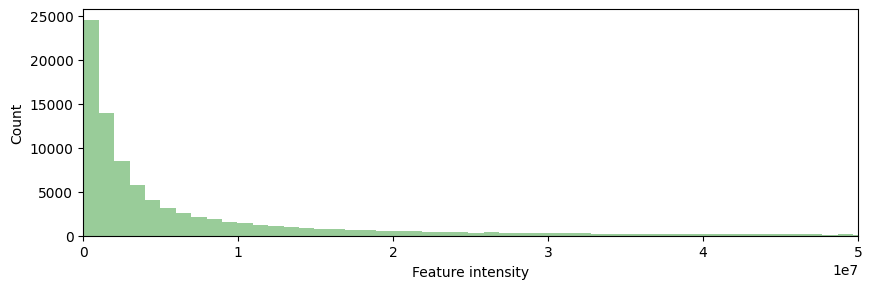

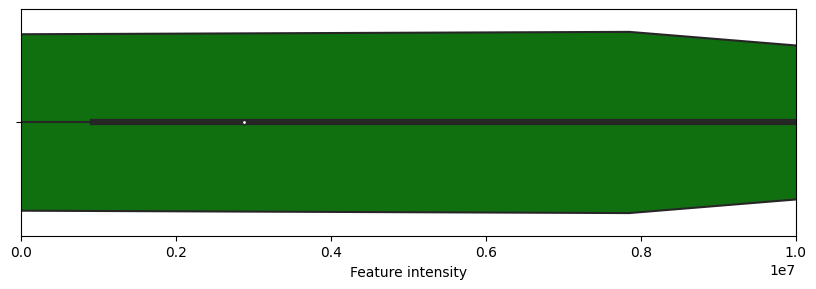

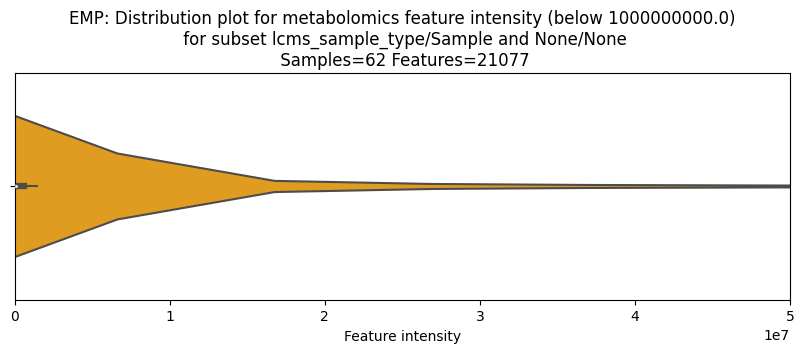

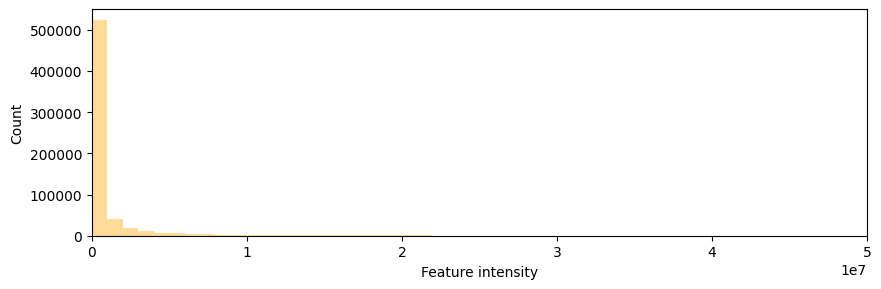

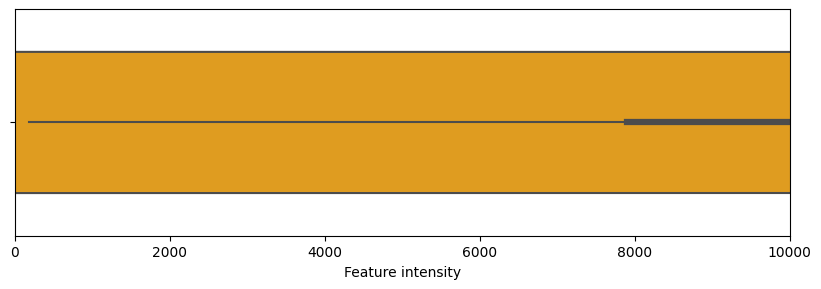

In [10]:
# View distribution for all SAMPLES
function(filename_before_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Sample", plot_color="green", xmax=5E7)
function(filename_after_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Sample", plot_color="orange", xmax=5E7, xmax_zoom=1E4)

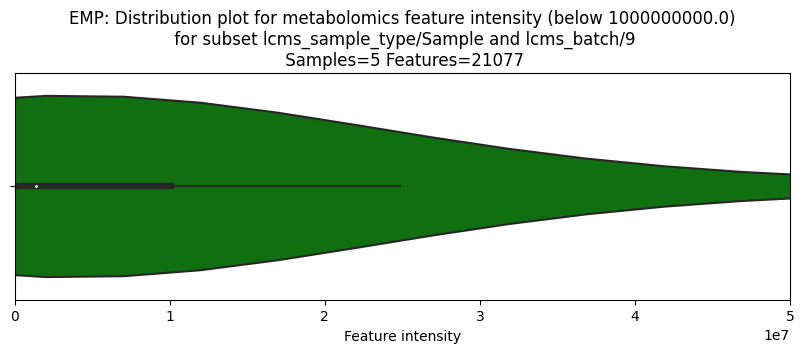

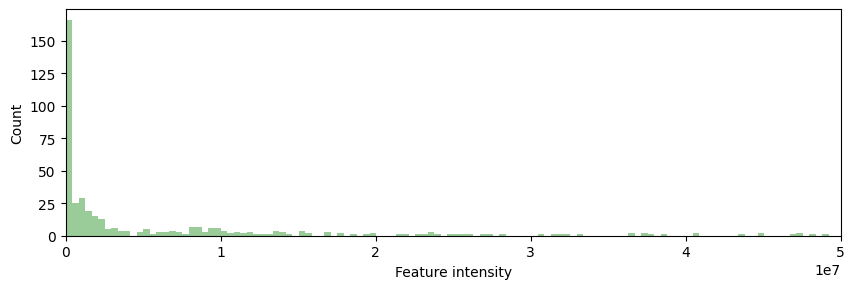

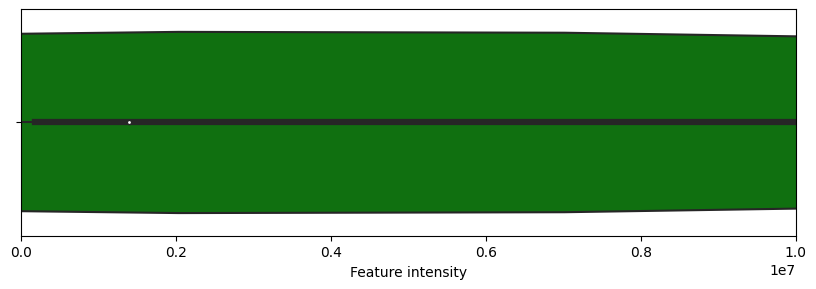

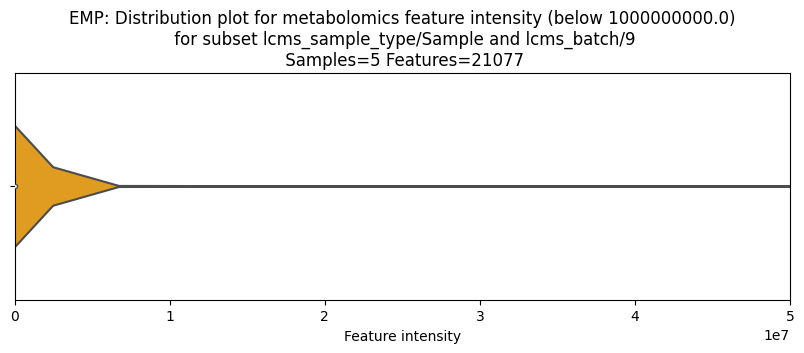

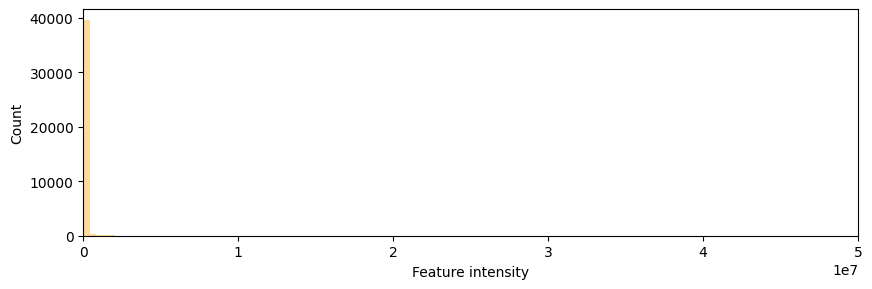

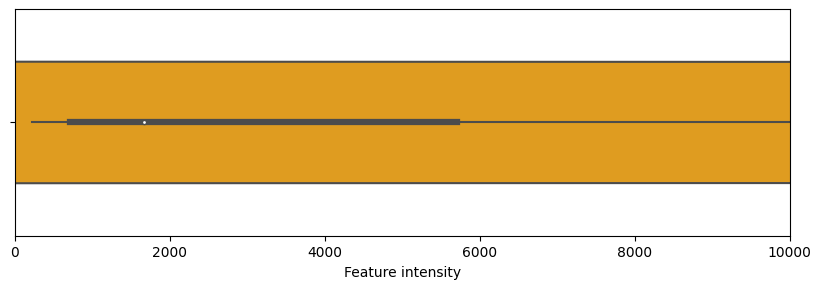

In [11]:
# View distribution for SAMPLES in batch 1
function(filename_before_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Sample", subset2="lcms_batch", value2=9, plot_color="green", xmax=5E7)
function(filename_after_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Sample", subset2="lcms_batch", value2=9, plot_color="orange", xmax=5E7, xmax_zoom=1E4)

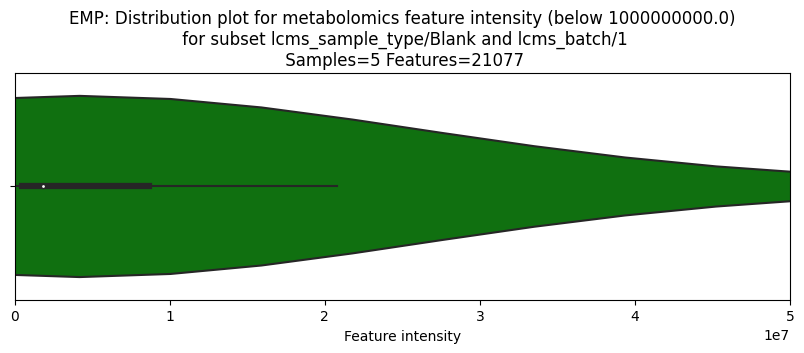

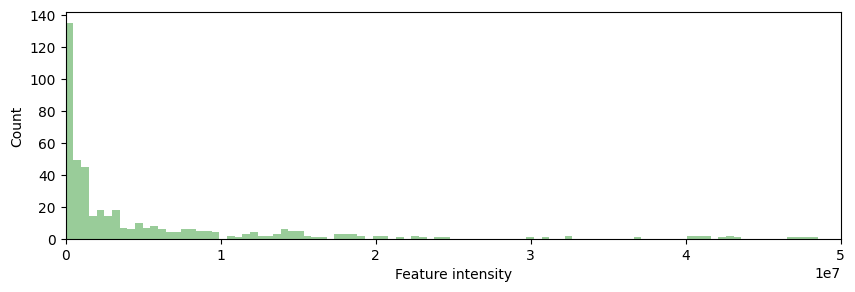

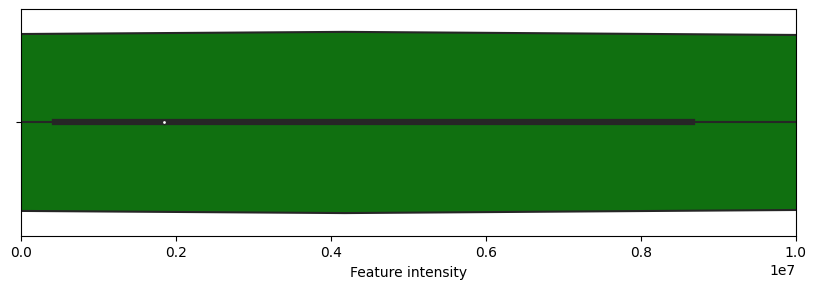

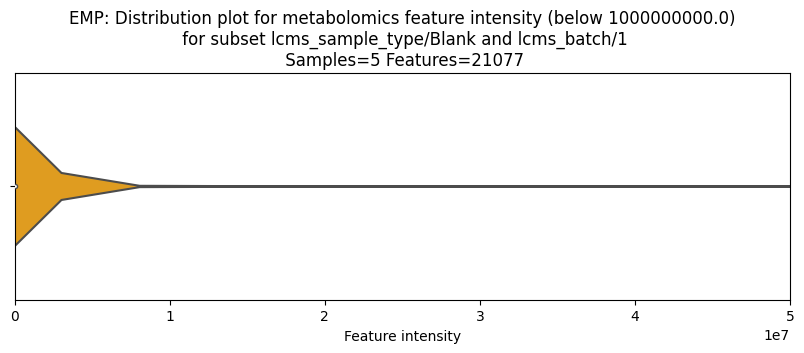

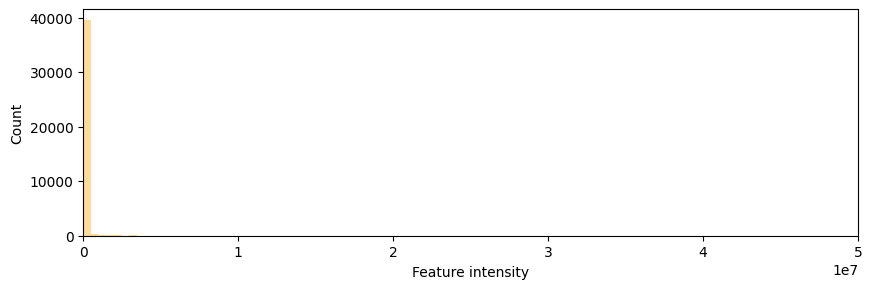

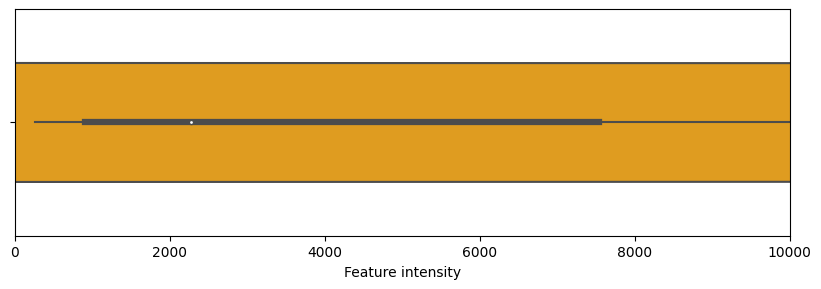

In [12]:
# View distribution for BLANKS in batch 1
function(filename_before_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Blank", subset2="lcms_batch", value2=1, plot_color="green", xmax=5E7)
function(filename_after_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Blank", subset2="lcms_batch", value2=1, plot_color="orange", xmax=5E7, xmax_zoom=1E4)

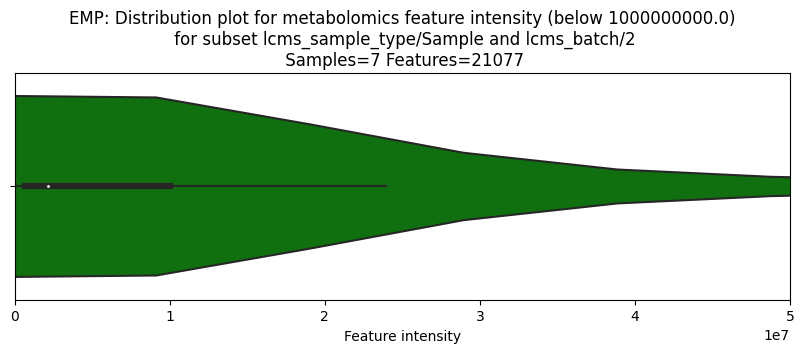

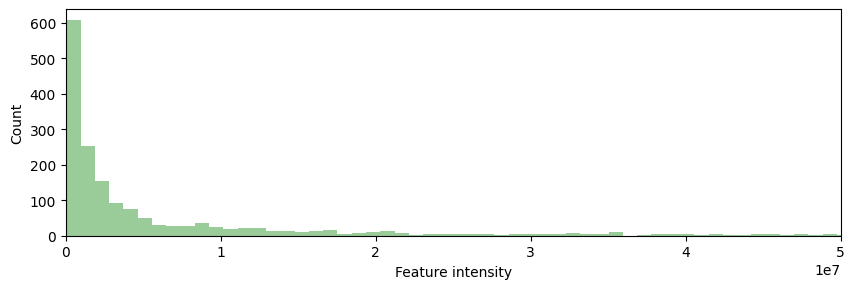

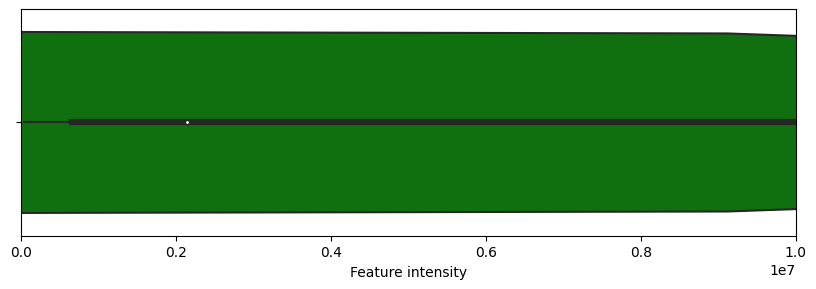

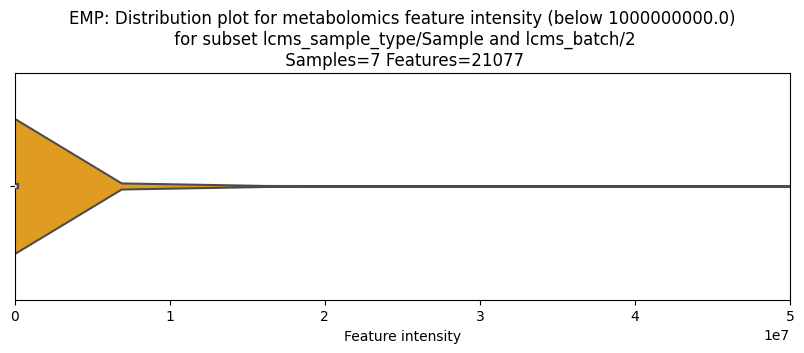

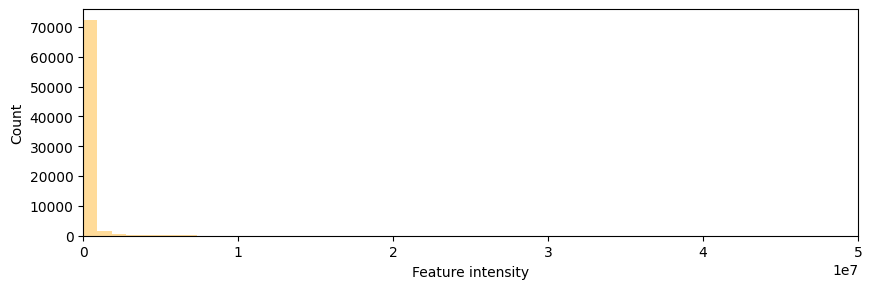

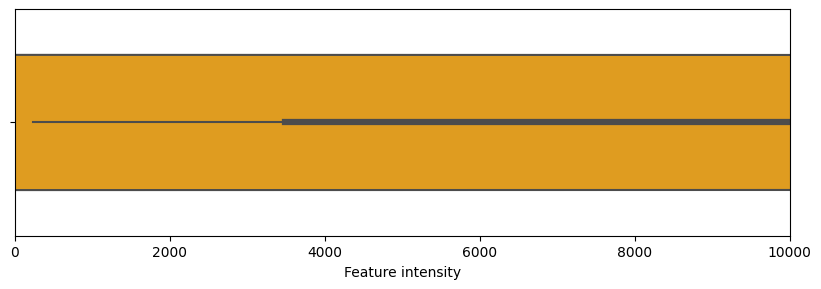

In [14]:
# View distribution for SAMPLES in batch 2
function(filename_before_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Sample", subset2="lcms_batch", value2=2, plot_color="green", xmax=5E7)
function(filename_after_gapfill, max_intensity=1E9, subset1="lcms_sample_type", value1="Sample", subset2="lcms_batch", value2=2, plot_color="orange", xmax=5E7, xmax_zoom=1E4)